## Segmenting and Clustering Neighborhoods in Toronto
### Peer Graded Assignment

In this project we will be clustering Toronto neighborhoods.

First, lets build the code to scrape the table of postal codes and then transform that data into a pandas dataframe.
The table is found in the following Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

We will be using **Beautiful Soup** which is a Python library for pulling data out of HTML and XML files. It will save us a lot of time for this task!

In [1]:
import numpy as np
import pandas as pd
import wikipedia as wp
from bs4 import BeautifulSoup
import requests

To create the data frame:
- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11  in the above table.
- If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

#### 1) Get the data
With the wikipedia library we just need to write the name of the article.

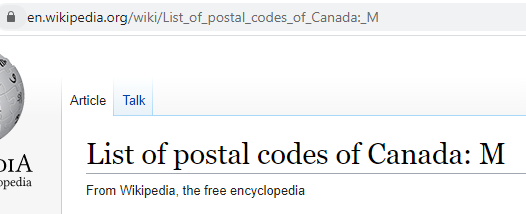


In [2]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]

Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [3]:
df = df[df.Borough!= "Not assigned"]

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood.

Lets combine them.

In [4]:
df = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [5]:
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

We Define columns, instantiate Dataframe and show how it looks

In [6]:
column_names = ['Postcode','Borough', 'Neighborhood'] 
df.columns = column_names
df.head(12)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [7]:
df.shape

(103, 3)

### 2) Get Coordinates
We can easily use **io** library to decode the coordinates from the csv file and then use the **join** method to add it to our dataframe.

In [8]:
import io

url="https://cocl.us/Geospatial_data"
geos=requests.get(url).content
coords=pd.read_csv(io.StringIO(geos.decode('utf-8')))

dfc = df.join(coords.set_index('Postal Code'), on='Postcode')
dfc.head(12)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


### 3) Explore and cluster data

We will need to import more libraries to explore, cluster and plot the data.

With geopy library we can easily define the geocoder instance to get the latitude and longitude values of Toronto.

In [9]:
from geopy.geocoders import Nominatim
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


##### We can now create a map showing the superimposed neighborhoods of toronto.

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dfc['Latitude'], dfc['Longitude'], dfc['Borough'], dfc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Moving on, we are goin to use Foursquare API to explore the neighborhoods.

#### Lets define Foursquare Credentials and Version.

In [11]:
CLIENT_ID = 'NE1SWN5IPGZ40I2IGUCRGKENJWLX2H0P0ZU0Y1BSXSKYDDSI' # your Foursquare ID
CLIENT_SECRET = 'TSPODANLGZ4RQ4VVKHQBN30KWPT0S34P5IYK43YTQDNCEPDL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

Your credentails:
CLIENT_ID: NE1SWN5IPGZ40I2IGUCRGKENJWLX2H0P0ZU0Y1BSXSKYDDSI
CLIENT_SECRET:TSPODANLGZ4RQ4VVKHQBN30KWPT0S34P5IYK43YTQDNCEPDL


'https://api.foursquare.com/v2/venues/search?client_id=NE1SWN5IPGZ40I2IGUCRGKENJWLX2H0P0ZU0Y1BSXSKYDDSI&client_secret=TSPODANLGZ4RQ4VVKHQBN30KWPT0S34P5IYK43YTQDNCEPDL&ll=43.6534817,-79.3839347&v=20180604&radius=500&limit=100'

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
#Send the GET request and examine the results
results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-13-45219f05457d>:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.country,location.formattedAddress,location.address,location.crossStreet,location.postalCode,location.city,location.state,location.neighborhood
0,4c093ee0340720a153728493,City Hall Council Chambers,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1610675441,False,43.651827,-79.383949,"[{'label': 'display', 'lat': 43.65182710471462...",184,CA,Canada,[Canada],NaN,NaN,NaN,NaN,NaN,NaN
1,4ad4c05ef964a5208ff620e3,Toronto City Hall,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1610675441,False,43.653140,-79.383967,"[{'label': 'display', 'lat': 43.65313989695342...",38,CA,Canada,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...",100 Queen St. W.,at Bay St.,M5H 2N2,Toronto,ON,NaN
2,4b06ef4cf964a52072f322e3,Cafe On The Square,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1610675441,False,43.652633,-79.383361,"[{'label': 'display', 'lat': 43.65263298456729...",105,CA,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",100 Queen St W,NaN,M5H 2N2,Toronto,ON,NaN
3,5df3211b7275f80008bc1f40,Nathan Phillips Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1610675441,False,43.652624,-79.383544,"[{'label': 'display', 'lat': 43.652624, 'lng':...",100,CA,Canada,"[Toronto ON M5H 2N2, Canada]",NaN,NaN,M5H 2N2,Toronto,ON,NaN
4,5b193c42598e64002ca79b96,City of Toronto Civic Innovation Office,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1610675441,False,43.653454,-79.383952,"[{'label': 'display', 'lat': 43.653454, 'lng':...",3,CA,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",100 Queen St W,NaN,M5H 2N2,Toronto,ON,NaN


In [14]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,lat,lng,labeledLatLngs,distance,cc,country,formattedAddress,address,crossStreet,postalCode,city,state,neighborhood,id
0,City Hall Council Chambers,City Hall,43.651827,-79.383949,"[{'label': 'display', 'lat': 43.65182710471462...",184,CA,Canada,[Canada],NaN,NaN,NaN,NaN,NaN,NaN,4c093ee0340720a153728493
1,Toronto City Hall,City Hall,43.653140,-79.383967,"[{'label': 'display', 'lat': 43.65313989695342...",38,CA,Canada,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...",100 Queen St. W.,at Bay St.,M5H 2N2,Toronto,ON,NaN,4ad4c05ef964a5208ff620e3
2,Cafe On The Square,Restaurant,43.652633,-79.383361,"[{'label': 'display', 'lat': 43.65263298456729...",105,CA,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",100 Queen St W,NaN,M5H 2N2,Toronto,ON,NaN,4b06ef4cf964a52072f322e3
3,Nathan Phillips Square,Plaza,43.652624,-79.383544,"[{'label': 'display', 'lat': 43.652624, 'lng':...",100,CA,Canada,"[Toronto ON M5H 2N2, Canada]",NaN,NaN,M5H 2N2,Toronto,ON,NaN,5df3211b7275f80008bc1f40
4,City of Toronto Civic Innovation Office,City Hall,43.653454,-79.383952,"[{'label': 'display', 'lat': 43.653454, 'lng':...",3,CA,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",100 Queen St W,NaN,M5H 2N2,Toronto,ON,NaN,5b193c42598e64002ca79b96


#### Create function to know how many venues there are in Toronto

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Lets run the above function to create a new datafframe called toronro_venues.

In [16]:
#List of Neighborhood that have venues in Toronto
toronto_venues = getNearbyVenues(names=dfc['Neighborhood'],
                                   latitudes=dfc['Latitude'],
                                   longitudes=dfc['Longitude']
                                  )

toronto_venues.head()

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [17]:
print('{} venues were returned by Foursquare.'.format(toronto_venues.shape[0]))
toronto_venues.head()

2126 venues were returned by Foursquare.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [18]:
#Number of venues per neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,6,6,6,6,6,6


Now its time to find out how many unique categories can be curated from all the returned venues.

In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


#### From the last lab we can now analyze each neighborhood with the one hot encoding variable.

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
manhattan_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### By taking the mean of the frequency of currence of each category we are able to group rows by neighborhood.

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Next, I want to see the top 5 most common venues per neighborhood

In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4             Massage Studio  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1  Sandwich Place  0.14
2     Coffee Shop  0.14
3             Pub  0.14
4        Pharmacy  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.11
1                       Bank  0.11
2                       Park  0.05
3              Shopping Mall  0.05
4  Middle Eastern Restaurant  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0              Coffee Shop  0.08
1           Sandw

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### It is time to create a new dataframe and display the top 5 venues for each neighborhood

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Skating Rink,Breakfast Spot,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Pharmacy,Sandwich Place,Pub,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Fried Chicken Joint,Shopping Mall,Bridal Shop,Sandwich Place,Diner,Restaurant,Supermarket
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Hobby Shop,Pharmacy,Pizza Place,Pub,Café,Restaurant,Butcher


### Run k-means algorithm (Clustering)

I tried 4 clusters, but the k-means was able to find only 2, so I have adjusted the function to kclusters = 2

In [25]:
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

toronto_merged = dfc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged = toronto_merged.dropna()


toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0,Fast Food Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Golf Course,Bar,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Breakfast Spot,Restaurant,Rental Car Location,Bank,Medical Center,Mexican Restaurant,Intersection,Yoga Studio,Distribution Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Soccer Field,Korean BBQ Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bank,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Dim Sum Restaurant,Diner


#### Now, the moment we were all expecting, lets visualize on a map the distribution of clusters.

In [27]:
toronto_merged['ClusterLabels'] = toronto_merged['ClusterLabels'].astype(int)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
toronto_merged.loc[toronto_merged['ClusterLabels'] ==0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,0,Fast Food Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,Scarborough,0,Golf Course,Bar,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,Scarborough,0,Electronics Store,Breakfast Spot,Restaurant,Rental Car Location,Bank,Medical Center,Mexican Restaurant,Intersection,Yoga Studio,Distribution Center
3,Scarborough,0,Coffee Shop,Soccer Field,Korean BBQ Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,Scarborough,0,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bank,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Dim Sum Restaurant,Diner
...,...,...,...,...,...,...,...,...,...,...,...,...
96,North York,0,Furniture / Home Store,Intersection,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
97,North York,0,Fabric Shop,Food Service,Baseball Field,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Dim Sum Restaurant
99,Etobicoke,0,Pizza Place,Chinese Restaurant,Intersection,Coffee Shop,Sandwich Place,Middle Eastern Restaurant,Discount Store,Yoga Studio,Diner,Distribution Center
101,Etobicoke,0,Grocery Store,Pizza Place,Video Store,Sandwich Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Pharmacy,Dumpling Restaurant,Eastern European Restaurant


In [29]:
toronto_merged.loc[toronto_merged['ClusterLabels'] ==1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,1,Park,Intersection,Playground,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
21,North York,1,Park,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
23,North York,1,Park,Convenience Store,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
25,North York,1,Park,Food & Drink Shop,Pool,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
40,East York,1,Park,Convenience Store,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
44,Central Toronto,1,Park,Bus Line,Swim School,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dessert Shop
48,Central Toronto,1,Park,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
50,Downtown Toronto,1,Park,Playground,Trail,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
74,York,1,Park,Women's Store,Pool,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store
98,York,1,Park,Convenience Store,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
